In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("covtype.csv")
print("Shape:", df.shape)
print("Columns:", df.columns[:15], "...")  # first few columns
df.head()


Shape: (581012, 55)
Columns: Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1'],
      dtype='object') ...


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]

print("Unique target classes:", y.unique())


Unique target classes: [5 2 1 7 3 6 4]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
cont_cols = ["Elevation","Aspect","Slope",
             "Horizontal_Distance_To_Hydrology",
             "Vertical_Distance_To_Hydrology",
             "Horizontal_Distance_To_Roadways",
             "Hillshade_9am","Hillshade_Noon","Hillshade_3pm",
             "Horizontal_Distance_To_Fire_Points"]

scaler = StandardScaler()
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test[cont_cols] = scaler.transform(X_test[cont_cols])


In [6]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


In [7]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.86      0.89       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



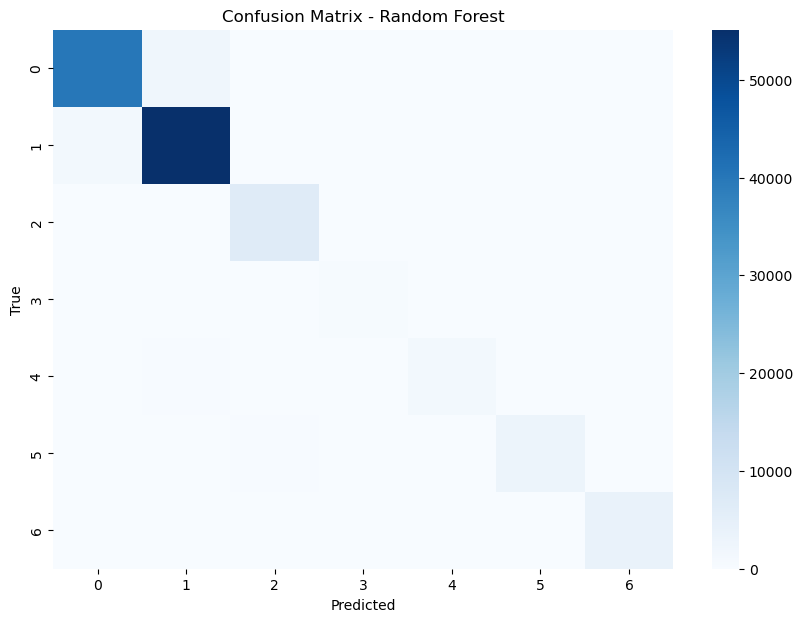

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.show()


/var/folders/zn/8zxzb6gn3zx2q2lhj093h58h0000gn/T/ipykernel_3700/747583413.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


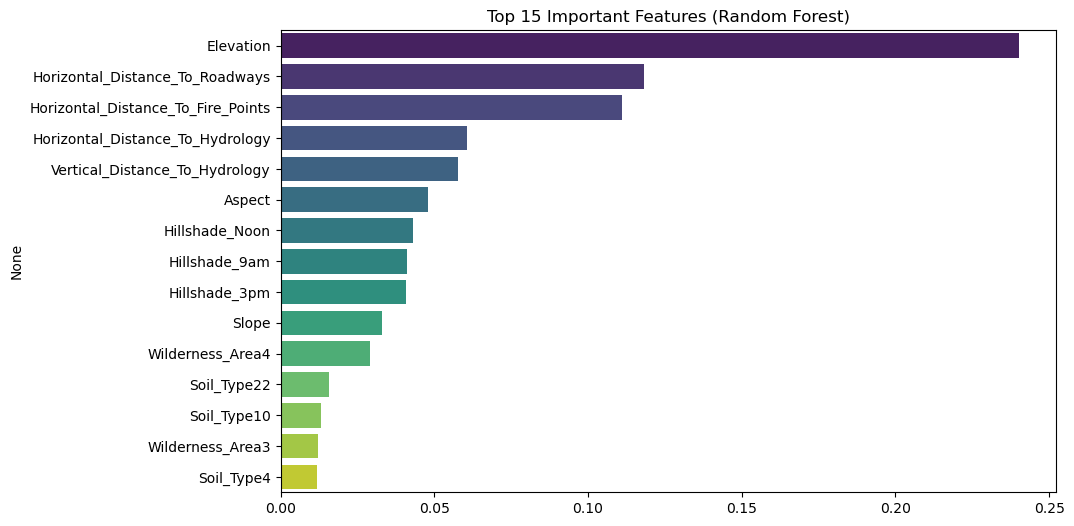

In [9]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 15 Important Features (Random Forest)")
plt.show()


In [10]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# XGBoost requires target to start from 0
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# Train XGBoost (latest version, no use_label_encoder warning)
xgb_model = XGBClassifier(
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train_xgb)

# Predictions (shift back to original labels)
y_pred_xgb = xgb_model.predict(X_test) + 1

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


Random Forest Accuracy: 0.953271430169617

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.86      0.89       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203

XGBoost Accuracy: 0.8696074972246843

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.84      0.85     42368
           2       0.87      0.90      0.88     56661
           3       0.89      0.91      0.90      7151
           4       0.88      0.86      0.87       549
   